In [1]:
import os, glob, shutil
import urllib.request as r
import kaggle

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "brain"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "project4", data_nomi = "brain")

Dataset yuklab olingan. project4/brain papkasini ni tekshiring.


In [2]:
import os, torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from PIL import Image
from torchvision import transforms as T

class CustomDataset(Dataset):
    
    def __init__(self, data_yulagi, transformations = None):
        super().__init__()
        

        self.im_paths = glob(f"{data_yulagi}/*/*.png")
        print(len(self.im_paths))
        self.transformations = transformations
        self.klass_nomlari = {}
        klass_qiymati = 0
        
        for idx, yulak in enumerate(self.im_paths):
            klass_nomi = self.get_cls_names(yulak, di_uchun = True)
            if klass_nomi not in self.klass_nomlari: self.klass_nomlari[klass_nomi] = klass_qiymati; klass_qiymati += 1
        
    def __len__(self): return len(self.im_paths)

    def get_cls_names(self, yulak, di_uchun = False): return (Image.open(yulak), self.klass_nomlari[os.path.basename(os.path.dirname(yulak))]) if not di_uchun else os.path.basename(os.path.dirname(yulak)) 
     
    def __getitem__(self, idx): 
        
        rasm, javob = self.get_cls_names(self.im_paths[idx], di_uchun = False)
        if self.transformations: rasm = self.transformations(rasm)
        
        return rasm, javob
    
        
data_yulagi = "../Downloads/project4/brain/brain/images"
tfs = T.Compose([T.Resize((224, 224)), T.ToTensor()])
model = CustomDataset(data_yulagi = data_yulagi, transformations = tfs)    
klass_nomlari = model.klass_nomlari
print(klass_nomlari)
model[100][0].shape

259
{'aneurysm': 0, 'cancer': 1, 'tumor': 2}


torch.Size([3, 224, 224])

In [3]:
from torch.utils.data import random_split, Dataset, DataLoader

tr_length = len(model)
tr_len = int(tr_length * 0.8)
val_len = int(tr_length * 0.1)
test_len = tr_length - tr_len - val_len

tr_ds, val_ds, ts_ds = random_split(model, [tr_len, val_len, test_len])

print(f"Train datasetda {len(tr_ds)} ta data bor")
print(f"Val datasetda {len(val_ds)} ta data bor")
print(f"Test datasetda {len(ts_ds)} ta data bor")

Train datasetda 207 ta data bor
Val datasetda 25 ta data bor
Test datasetda 27 ta data bor


In [4]:
bs = 16
train_dl = DataLoader(tr_ds, shuffle = True, batch_size = bs, num_workers = 0)
validation_dl = DataLoader(val_ds, shuffle = False, batch_size = bs, num_workers = 0)
test_dl = DataLoader(ts_ds, shuffle = False, batch_size = 1, num_workers = 0)
print(len(train_dl))
print(len(validation_dl))
print(len(test_dl))

13
2
27


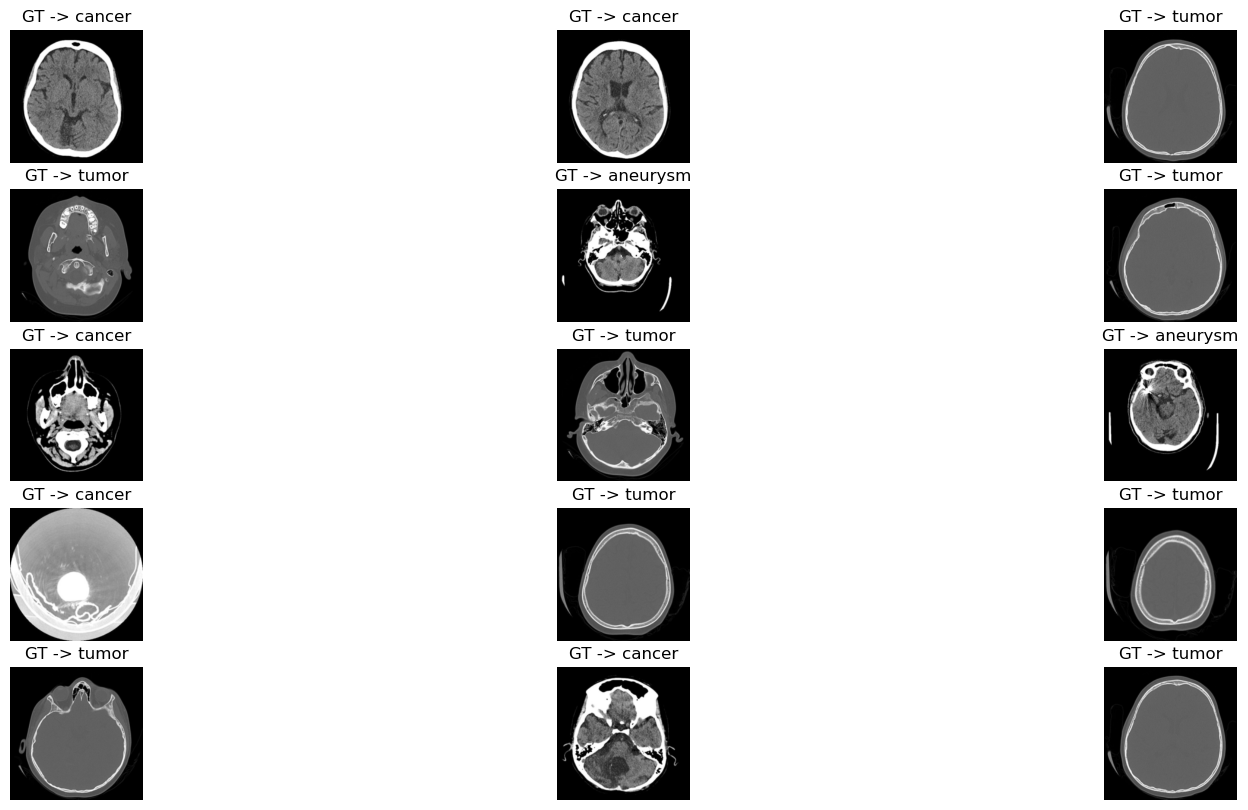

In [5]:
import random
from matplotlib import pyplot as plt
class_names = ['aneurysm', 'cancer', 'tumor']

def visualize(data, images_num, rows, cls_names = None):
    
    indexs = [random.randint(0, len(data) - 1) for _ in range(images_num)]
    plt.figure(figsize=[20, 10])
    for idx, index in enumerate(indexs):
        image, answer = data[index]
        plt.subplot(rows, images_num // rows, idx + 1)
        plt.imshow(((image)*255).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
        if cls_names : plt.title(f"GT -> {cls_names[answer]}")
        else: plt.title(f"GT -> {answer}") 
visualize(data = train_dl.dataset, images_num = 15, rows = 5, cls_names = class_names)    

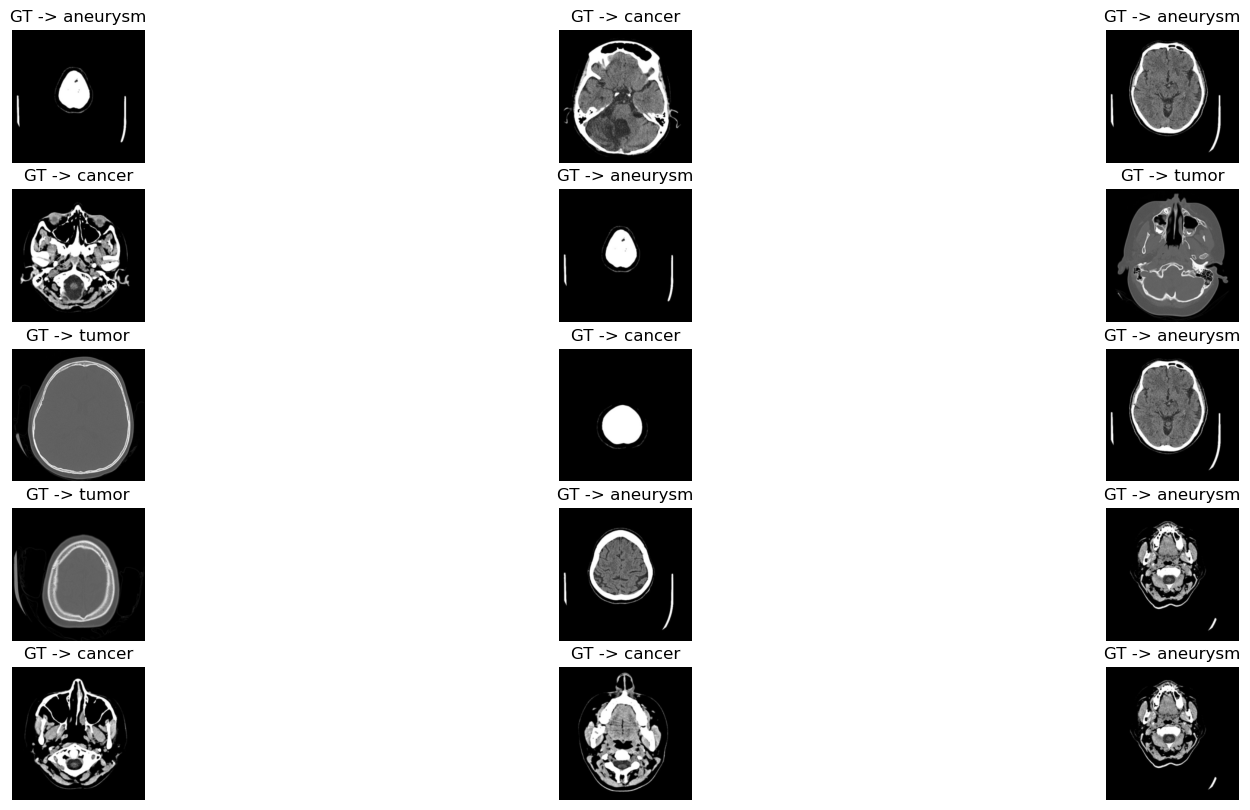

In [6]:
import random, numpy as np
from matplotlib import pyplot as plt
class_names = ['aneurysm', 'cancer', 'tumor']

def visualize(data, images_num, rows, cls_names = None):
    
    indexs = [random.randint(0, len(data) - 1) for _ in range(images_num)]
    plt.figure(figsize=[20, 10])
    for idx, index in enumerate(indexs):
        image, answer = data[index]
        plt.subplot(rows, images_num // rows, idx + 1)
        plt.imshow(((image)*255).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
        if cls_names : plt.title(f"GT -> {cls_names[answer]}")
        else: plt.title(f"GT -> {answer}") 
visualize(data = validation_dl.dataset, images_num = 15, rows = 5, cls_names = class_names) 

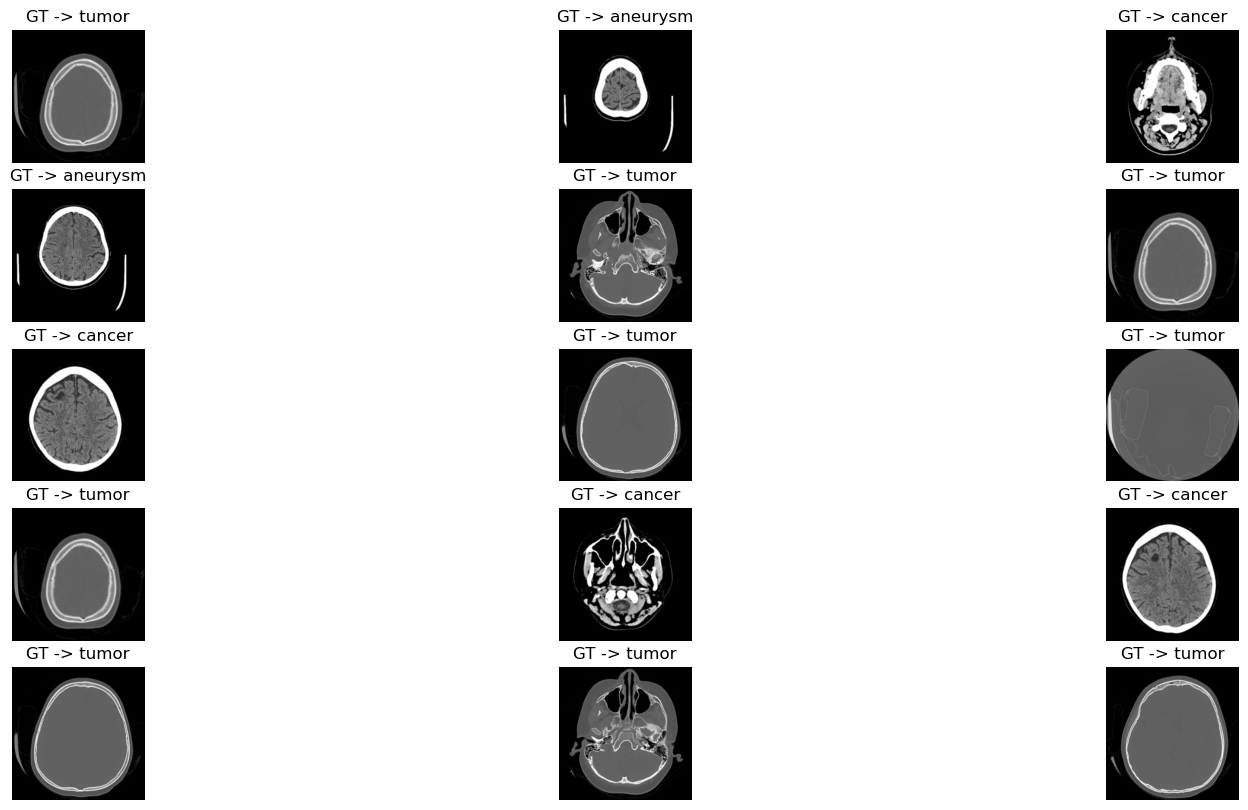

In [7]:
import random
from matplotlib import pyplot as plt
class_names = ['aneurysm', 'cancer', 'tumor']

def visualize(data, images_num, rows, cls_names = None):
    
    indexs = [random.randint(0, len(data) - 1) for _ in range(images_num)]
    plt.figure(figsize=[20, 10])
    for idx, index in enumerate(indexs):
        image, answer = data[index]
        plt.subplot(rows, images_num // rows, idx + 1)
        plt.imshow(((image)*255).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
        if cls_names : plt.title(f"GT -> {cls_names[answer]}")
        else: plt.title(f"GT -> {answer}") 
visualize(data = test_dl.dataset, images_num = 15, rows = 5, cls_names = class_names) 

In [8]:
import timm

Model = timm.create_model('resnet18', pretrained = True, num_classes = len(class_names))
Model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [9]:
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
Model.to(device)
loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = Model.parameters(), lr = 1e-3)

In [10]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in tqdm(enumerate(tr_dl)):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(val_dl):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.3f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.3f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.3f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)

          # print(type(best_loss))

          if VAL_epoc_loss < best_loss:
              os.makedirs("best_model3", exist_ok=True)
              best_loss = VAL_epoc_loss
              torch.save(model.state_dict(), f"best_model3/{save_prefix}_best_model.pth")

  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}


result = train(model=Model, tr_dl=train_dl, val_dl=validation_dl, epochs=10, device=device,
               loss_fc=loss_fc, opt=optimazer, save_prefix="brain")

Train is starting .....
1- epoc is starting..


13it [00:03,  4.26it/s]


1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.522
1- epoc Validation Accurancy score   -> 0.800
1- epoc Validation loss score        -> 0.577


2- epoc is starting..


13it [00:00, 14.86it/s]


2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.928
2- epoc Validation Accurancy score   -> 0.960
2- epoc Validation loss score        -> 0.127


3- epoc is starting..


13it [00:00, 15.13it/s]


3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.966
3- epoc Validation Accurancy score   -> 1.000
3- epoc Validation loss score        -> 0.038


4- epoc is starting..


13it [00:00, 14.30it/s]


4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.937
4- epoc Validation Accurancy score   -> 1.000
4- epoc Validation loss score        -> 0.038


5- epoc is starting..


13it [00:00, 14.41it/s]


5 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 - epoc result:

5- epoc Train Accurancy score        -> 0.995
5- epoc Validation Accurancy score   -> 1.000
5- epoc Validation loss score        -> 0.001


6- epoc is starting..


13it [00:00, 14.48it/s]


6 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6 - epoc result:

6- epoc Train Accurancy score        -> 0.995
6- epoc Validation Accurancy score   -> 0.960
6- epoc Validation loss score        -> 0.042


7- epoc is starting..


13it [00:00, 14.07it/s]


7 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7 - epoc result:

7- epoc Train Accurancy score        -> 0.942
7- epoc Validation Accurancy score   -> 1.000
7- epoc Validation loss score        -> 0.004


8- epoc is starting..


13it [00:00, 13.33it/s]


8 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
8 - epoc result:

8- epoc Train Accurancy score        -> 0.981
8- epoc Validation Accurancy score   -> 1.000
8- epoc Validation loss score        -> 0.005


9- epoc is starting..


13it [00:00, 13.93it/s]


9 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9 - epoc result:

9- epoc Train Accurancy score        -> 0.986
9- epoc Validation Accurancy score   -> 1.000
9- epoc Validation loss score        -> 0.002


10- epoc is starting..


13it [00:00, 14.86it/s]

10 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
10 - epoc result:

10- epoc Train Accurancy score        -> 0.995
10- epoc Validation Accurancy score   -> 1.000
10- epoc Validation loss score        -> 0.002




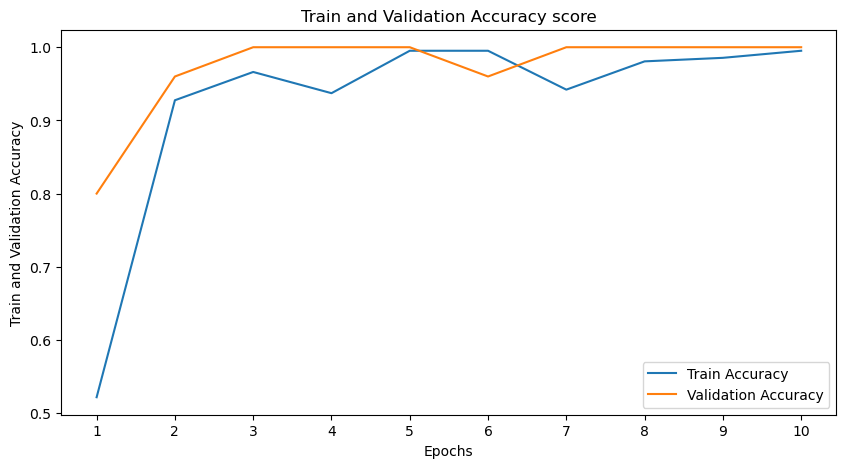

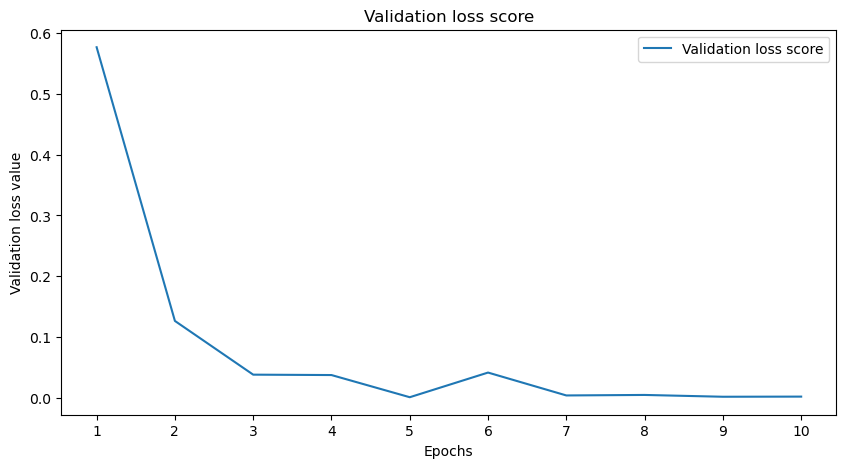

In [11]:
class visualize():
    def __init__(self, res):
      
        plt.figure(figsize=(10,5))
        plt.title("Train and Validation Accuracy score")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation Accuracy")
        plt.plot(res['tr_acc_sc'], label = "Train Accuracy")
        plt.plot(res['val_acc_sc'], label = "Validation Accuracy")
        plt.xticks(np.arange(len(res['val_acc_sc'])), [i for i in range(1, len(res['val_acc_sc']) + 1)])
        #plt.ylim(0, 1)
        plt.legend()
        
        plt.figure(figsize=(10,5))
        plt.title("Validation loss score")
        plt.xlabel("Epochs")
        plt.ylabel("Validation loss value")
        plt.plot(res['val_epoc_loss'], label = "Validation loss score")
        plt.xticks(np.arange(len(res['val_epoc_loss'])), [i for i in range(1, len(res['val_epoc_loss']) + 1)])
        plt.legend()
        plt.show()
visualize(result)        

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


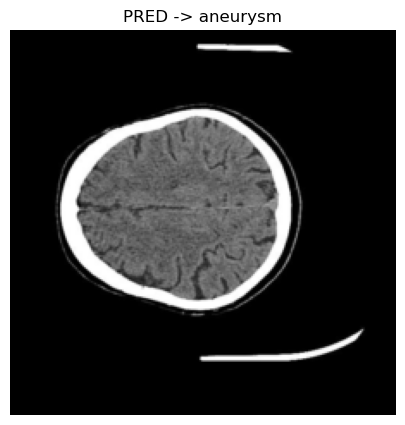

torch.Size([3, 224, 224])


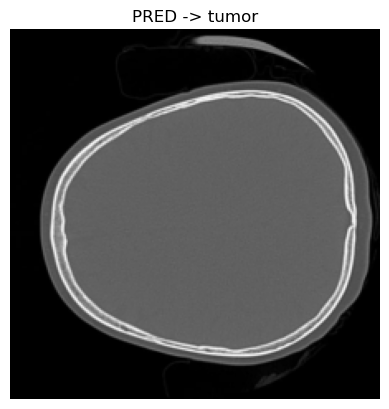

torch.Size([3, 224, 224])


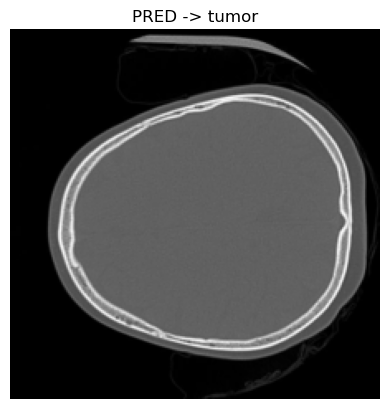

torch.Size([3, 224, 224])


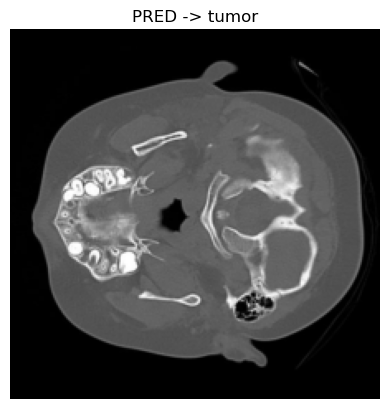

torch.Size([3, 224, 224])


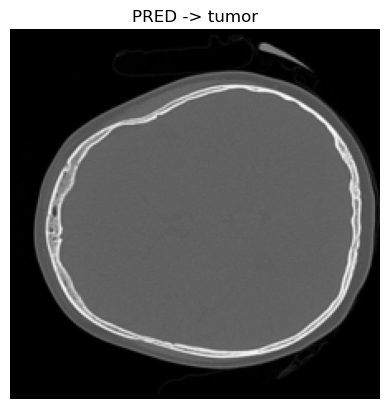

In [12]:
import random
def inference(data, model, num_of_img, device, cls_names = None):
    predictions = []
    images = []
    
    for idx, x in enumerate(data):
        if idx == 10: break
        img, label = x
        print(type(img))
        img, label = img.to(device), label.to(device)
        pred = model(img)
        pred_cls = torch.argmax(pred, dim = 1)
        predictions.append(pred_cls)
        images.append(img)
    indeks = [random.randint(0, len(images)-1) for _ in range(num_of_img)]
    plt.figure(figsize=(10, 5))
    
    for idx, indek in enumerate(indeks):
        img = images[indek][0]
        print(img.shape)
        
        plt.imshow(((img)*255).cpu().permute(2,1,0).numpy().astype('uint8'))
        plt.axis('off')
        plt.title(f"PRED -> {cls_names[predictions[indek][0]]}")
        plt.show()
inference(data = test_dl, model = Model.to(device), num_of_img = 5, device = device, cls_names = list(class_names))        
model = torch.load('best_model3/brain_best_model.pth')    

In [13]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

In [14]:
!pip install grad-cam

27it [00:00, 76.05it/s]


Accuracy of the model on the test data -> 0.926
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)
(1, 224, 224)


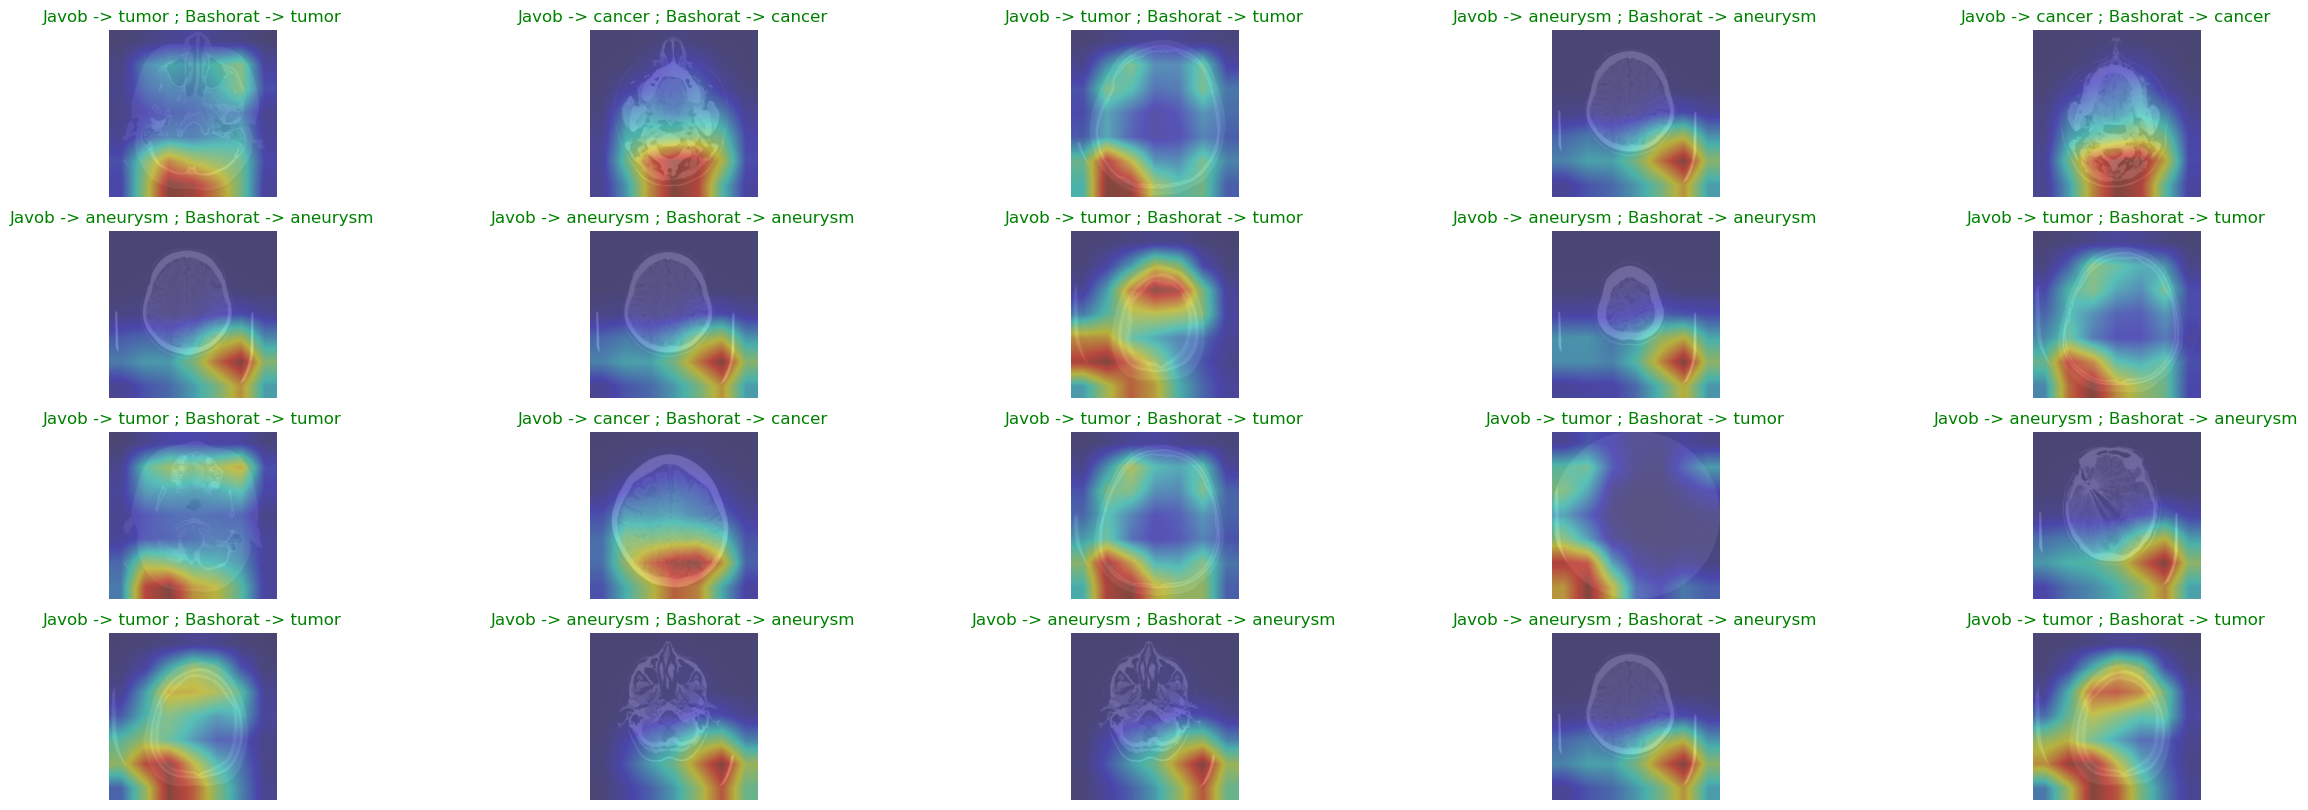

In [36]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

def inference(model, device, test_dl, num_ims, row, klass_nomlari = None, rasm_hajmi = None):
    
    aniqlilik = 0
    hamma_bashoratlar, hamma_rasmlar, hamma_javoblar = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        #if idx == 3: break
        rasmlar, javoblar = batch
        rasmlar, javoblar = rasmlar.to(device), javoblar.to(device)
        bashoratlar = torch.argmax(model(rasmlar), dim = 1)
        aniqlilik += (bashoratlar == javoblar).sum().item()
        hamma_rasmlar.append(rasmlar)
        hamma_bashoratlar.append(bashoratlar.item())
        hamma_javoblar.append(javoblar.item())
    
    print(f"Accuracy of the model on the test data -> {(aniqlilik / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (30, 10))
    indekslar = [random.randint(0, len(hamma_rasmlar) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        rasm = hamma_rasmlar[indeks].squeeze()
        javob = hamma_javoblar[indeks]; bashorat = hamma_bashoratlar[indeks]
        
        orig_rasm = tensor_2_im(rasm) / 255
        
        cam = GradCAMPlusPlus(model = model, target_layers = [model.layer4[-1]]) #, use_cuda = True
        print(cam(input_tensor = rasm.unsqueeze(0)).shape)
        grayscale_cam = cam(input_tensor = rasm.unsqueeze(0))[0, :]
        heatmap = show_cam_on_image(img = orig_rasm, mask = grayscale_cam, image_weight = 0.2, use_rgb = True)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(rasm), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (rasm_hajmi, rasm_hajmi), interpolation = cv2.INTER_LINEAR), alpha = 0.5, cmap = "gray"); plt.axis("off")
        
        rang = ("green" if {klass_nomlari[int(javob)]} == {klass_nomlari[int(bashorat)]} else "red")
        if klass_nomlari: plt.title(f"Javob -> {klass_nomlari[javob]} ; Bashorat -> {klass_nomlari[bashorat]}", color = rang)
        else: plt.title(f"Javob -> {javob} ; Bashorat -> {bashorat}")
        
Model.load_state_dict(torch.load('best_model3/brain_best_model.pth'))
Model.eval()
inference(model = Model.to(device), device = device, test_dl = test_dl, num_ims = 20, row = 4, klass_nomlari = list(class_names), rasm_hajmi = 224)